# fMRI Models

This notebook generates design information for all models used at different points in the paper.

In [1]:
%matplotlib inline

In [2]:
import os
import os.path as op
import numpy as np
from scipy import stats
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from moss import glm
from moss.design import build_simple_ev, build_condition_ev, build_parametric_ev
import lyman

In [3]:
os.environ["LYMAN_DIR"] = op.abspath("../lyman/")

In [4]:
subjects = lyman.determine_subjects()
data_dir = lyman.gather_project_info()["data_dir"]
design_template = op.join(data_dir, "{subj}/design/{design_name}.csv")

Make sure the output directories exist

In [5]:
for s in subjects:
    design_dir = op.join(data_dir, s, "design")
    if not op.exists(design_dir):
        os.mkdir(design_dir)

Utility functions

In [6]:
def make_designs(func):
    """Apply a design creation function to each subject in the full dataset."""
    data = pd.read_csv("data/punch_data.csv")
    for subj, subj_data in data.groupby("subj"):
        func(subj_data.copy(), subj)

In [7]:
def save_design(parts, subj, name):
    """Concatenate component design parts and write to the data directory."""
    design = pd.concat(parts).sort(["run", "onset", "condition"])
    fname = design_template.format(subj=subj, design_name=name)
    design.to_csv(fname, index=False)

In [8]:
def check_design(design_name, subj="pc07", run=4):
    """Load a single-run design matrix to check that everything looks ok."""
    d = pd.read_csv(design_template.format(subj=subj, design_name=design_name))
    X = glm.DesignMatrix(d[d.run == run], glm.GammaDifferenceHRF(), 235)
    return X

---

## Parametric CPE

This model examines the parametric effect of CPE while controlling for response time and errors.

In [9]:
def cpe_main(data, subj):

    # Subsets of the dataset
    data_error = data.query("not correct")
    data_resp = data.query("answered and stim")
    data_resp_error = data_resp.query("not correct")

    # Main effect of task
    task = build_simple_ev(data, onset="cue_onset", name="task", duration="model_dur")

    # Main effect of response errors
    error = build_simple_ev(data_error, onset="cue_onset", name="error", duration="model_dur")

    # Parametric regressor for context prediction error
    cpe = build_parametric_ev(data, onset="cue_onset", name="cpe", value="pe_context",
                              duration="model_dur", scale=stats.zscore)

    # Interaction between CPE and response errors
    error_x_cpe = build_parametric_ev(data_error, onset="cue_onset", name="error_x_cpe",
                                      value="pe_context", duration="model_dur",
                                      scale=stats.zscore)

    # Parametric regressor for response time
    rt = build_parametric_ev(data_resp, onset="cue_onset", name="response_time",
                             value="rt", duration="model_dur", scale=stats.zscore)

    # Interaction between RT regressor and response errors
    error_x_rt = build_parametric_ev(data_resp_error, onset="cue_onset", name="error_x_rt",
                                     value="rt", duration="model_dur", scale=stats.zscore)

    save_design([task, error, cpe, error_x_cpe, rt, error_x_rt], subj, "cpe_main")

In [10]:
make_designs(cpe_main)

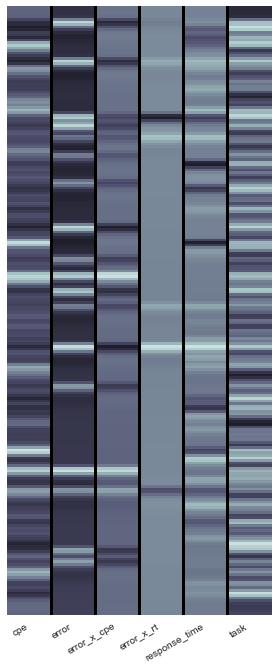

In [11]:
X = check_design("cpe_main")
X.plot();

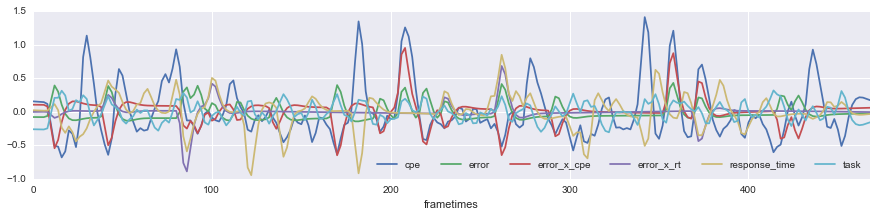

In [12]:
X.design_matrix.plot(figsize=(15, 3))
plt.legend(ncol=6, loc="best");

----

## Parametric CPE split by cue and stim

This model examines the parametric effect of CPE separately during cue and stimulus processing while controlling for response time and errors.

In [13]:
def cpe_cuestim(data, subj):

    # Subsets of the dataset
    data_cue = data.query("trial_type != 'later'")
    data_stim = data.query("trial_type != 'catch'")

    data_error = data_stim.query("not correct")
    data_resp = data_stim.query("answered")
    data_resp_error = data_resp.query("not correct")

    # Compute average RT
    # (used for duration of stim events)
    rt_mean = data_resp.rt.mean()

    # Main effect of cue
    cue = build_simple_ev(data_cue, onset="cue_onset", name="cue", duration=1)

    # Main effect of stim
    stim = build_simple_ev(data_stim, onset="stim_onset", name="stim", duration=rt_mean)

    # Main effect of response errors
    error = build_simple_ev(data_error, onset="stim_onset", name="error", duration=rt_mean)

    # Parametric regressor for CPE during cue periord
    cpe_cue = build_parametric_ev(data_cue, onset="cue_onset", name="cpe_cue", value="pe_context",
                                  duration=1, scale=stats.zscore)

    # Parametric regressor for CPE during stim periord
    cpe_stim = build_parametric_ev(data_stim, onset="stim_onset", name="cpe_stim", value="pe_context",
                                   duration=rt_mean, scale=stats.zscore)

    # Parametric regressor for response time during stim period
    rt = build_parametric_ev(data_resp, onset="stim_onset", name="response_time",
                             value="rt", duration=rt_mean, scale=stats.zscore)

    save_design([cue, stim, error, cpe_cue, cpe_stim, rt], subj, "cpe_cuestim")

In [14]:
make_designs(cpe_cuestim)

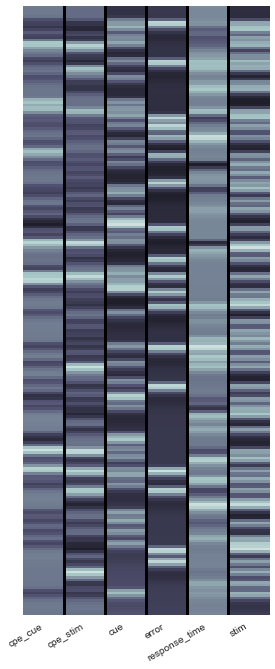

In [15]:
X = check_design("cpe_cuestim")
X.plot();

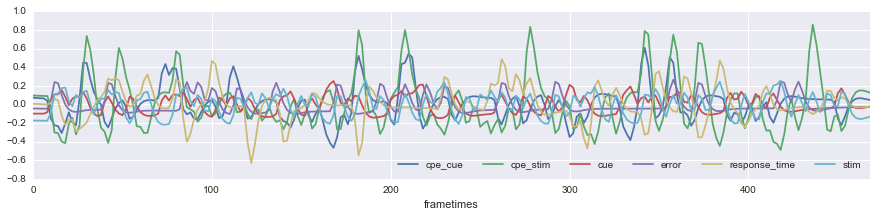

In [16]:
X.design_matrix.plot(figsize=(15, 3))
plt.legend(ncol=6, loc="best");

----

## Parametric CPE with context switches¶

In [17]:
def cpe_context_switch(data, subj):

    # Subsets of the dataset
    data_switch = data.query("context_switch")
    data_error = data.query("not correct")
    data_resp = data.query("answered and stim")
    data_resp_error = data_resp.query("not correct")

    # Main effect of task
    task = build_simple_ev(data, onset="cue_onset",
                           name="task", duration="model_dur")

    # Main effect of response errors
    error = build_simple_ev(data_error, onset="cue_onset",
                            name="error", duration="model_dur")

    # Main effect of context switches
    switch = build_simple_ev(data_switch, onset="cue_onset",
                             name="context_switch", duration="model_dur")
    
    # Parametric regressor for context prediction error
    cpe = build_parametric_ev(data, onset="cue_onset", name="cpe", value="pe_context",
                              duration="model_dur", scale=stats.zscore)

    # Interaction between CPE and response errors
    error_x_cpe = build_parametric_ev(data_error, onset="cue_onset", name="error_x_cpe",
                                      value="pe_context", duration="model_dur",
                                      scale=stats.zscore)

    # Parametric regressor for response time
    rt = build_parametric_ev(data_resp, onset="cue_onset", name="response_time",
                             value="rt", duration="model_dur", scale=stats.zscore)

    # Interaction between RT regressor and response errors
    error_x_rt = build_parametric_ev(data_resp_error, onset="cue_onset", name="error_x_rt",
                                     value="rt", duration="model_dur", scale=stats.zscore)

    save_design([task, error, switch, cpe, error_x_cpe, rt, error_x_rt], subj, "cpe_context_switch")

In [18]:
make_designs(cpe_context_switch)

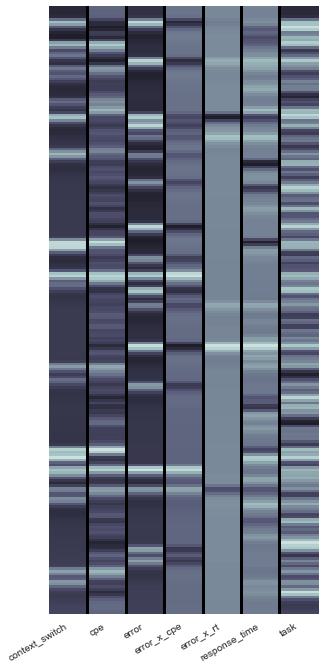

In [19]:
X = check_design("cpe_context_switch")
X.plot();

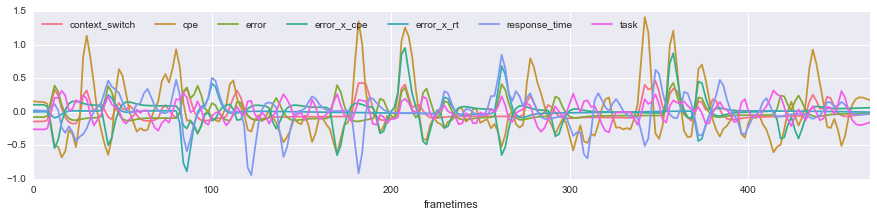

In [20]:
X.design_matrix.plot(figsize=(15, 3), color=sns.husl_palette(7))
plt.legend(ncol=7, loc="best");

----

## Cue, stimulus, and error events

Simple model for three kinds of task events

In [21]:
def cue_stim_error(data, subj):

    # Subsets of the data
    data_corr = data.query("correct")
    data_error = data.query("not correct")

    # Cue events
    cue = build_simple_ev(data.query("trial_type != 'later'"),
                          onset="cue_onset", name="cue")

    # Stimulus events
    stim = build_simple_ev(data_corr.query("trial_type != 'catch'"),
                           onset="stim_onset", name="stim")

    # Errors
    error = build_simple_ev(data_error, onset="stim_onset", name="error")

    save_design([cue, stim, error], subj, "cue_stim_error")

In [22]:
make_designs(cue_stim_error)

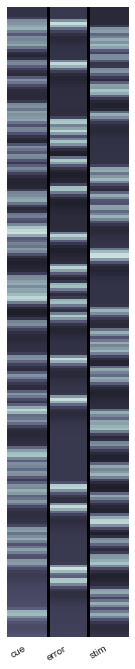

In [23]:
X = check_design("cue_stim_error")
X.plot()

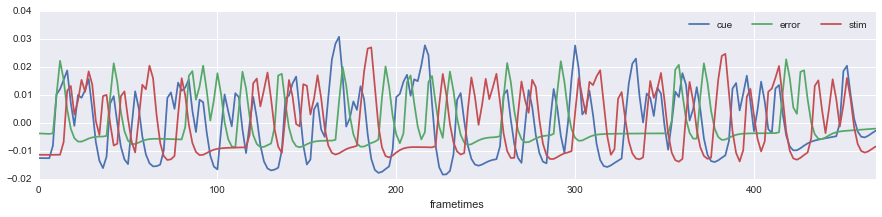

In [24]:
X.design_matrix.plot(figsize=(15, 3))
plt.legend(ncol=3);

----

## Task with RT and errors

Main effect of task, controlling for RT and errors

In [25]:
def task_rt_errors(data, subj):

    # Subsets of the dataset
    data_error = data.query("not correct")
    data_resp = data.query("answered and stim")
    data_resp_error = data_resp.query("not correct")

    # Main effect of task
    task = build_simple_ev(data, onset="cue_onset", name="task", duration="model_dur")

    # Main effect of response errors
    error = build_simple_ev(data_error, onset="cue_onset", name="error", duration="model_dur")

    # Parametric regressor for response time
    rt = build_parametric_ev(data_resp, onset="cue_onset", name="response_time",
                             value="rt", duration="model_dur", scale=stats.zscore)

    # Interaction between RT regressor and response errors
    error_x_rt = build_parametric_ev(data_resp_error, onset="cue_onset", name="error_x_rt",
                                     value="rt", duration="model_dur", scale=stats.zscore)

    save_design([task, error, rt, error_x_rt], subj, "task_rt_errors")

In [26]:
make_designs(task_rt_errors)

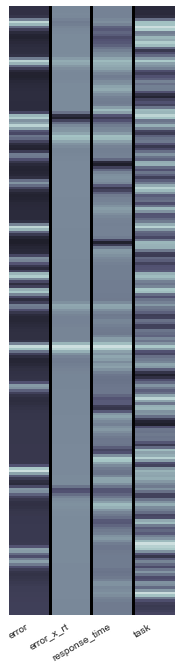

In [27]:
X = check_design("task_rt_errors")
X.plot()

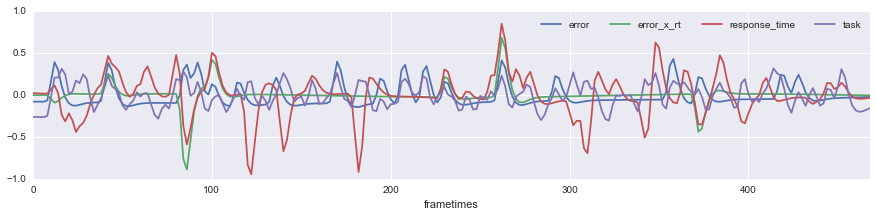

In [28]:
X.design_matrix.plot(figsize=(15, 3))
plt.legend(ncol=4);

----

## Task with RTs, errors, and context switches

In [29]:
def task_rt_errors_switch(data, subj):

    # Subsets of the dataset
    data_error = data.query("not correct")
    data_resp = data.query("answered and stim")
    data_resp_error = data_resp.query("not correct")
    data_switch = data.query("context_switch")

    # Main effect of task
    task = build_simple_ev(data, onset="cue_onset", name="task", duration="model_dur")

    # Main effect of response errors
    error = build_simple_ev(data_error, onset="cue_onset", name="error", duration="model_dur")

    # Main effect of task switch
    switch = build_simple_ev(data_switch, onset="cue_onset", name="context_switch", duration="model_dur")
    
    # Parametric regressor for response time
    rt = build_parametric_ev(data_resp, onset="cue_onset", name="response_time",
                             value="rt", duration="model_dur", scale=stats.zscore)

    # Interaction between RT regressor and response errors
    error_x_rt = build_parametric_ev(data_resp_error, onset="cue_onset", name="error_x_rt",
                                     value="rt", duration="model_dur", scale=stats.zscore)

    save_design([task, error, switch, rt, error_x_rt], subj, "task_rt_errors_switch")

In [30]:
make_designs(task_rt_errors_switch)

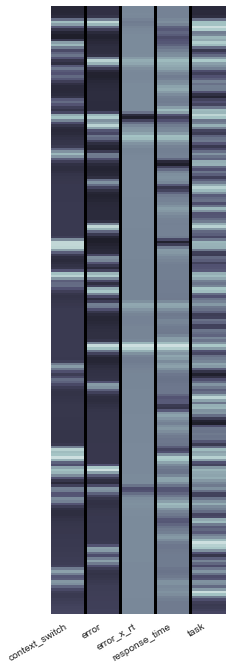

In [31]:
X = check_design("task_rt_errors_switch")
X.plot()

----

## Single context regressor

A single regressor that is 1 for motion trials and -1 for color trials

In [32]:
def context_single(data, subj):

    # Convert the semantic context column to a numeric one
    data.loc[:, "context_numeric"] = data.context.map({"motion": 1, "color":- 1})

    # Build the regressor
    context = build_parametric_ev(data, onset="cue_onset", name="context",
                                  value="context_numeric", duration="model_dur", center=0)

    save_design([context], subj, "context_single")

In [33]:
make_designs(context_single)

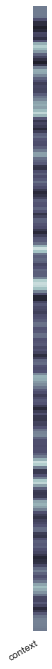

In [34]:
X = check_design("context_single")
X.plot()

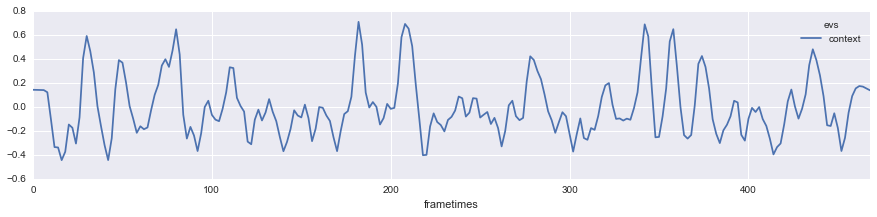

In [35]:
X.design_matrix.plot(figsize=(15, 3));

----

##  Context single by frame

In [36]:
def context_single_by_frame(data, subj):

    frames = []

    # Convert the semantic context column to a numeric one
    data["context_numeric"] = data.context.map({"motion": 1, "color":- 1})

    # Loop over the two possible frames for each context
    for frame in [0, 1]:
        
        frame_data = data.query("cue == @frame")

        # Build the regressor
        context = build_parametric_ev(frame_data, onset="cue_onset", name="context_{:d}".format(frame),
                                      value="context_numeric", duration="model_dur", center=0)

        frames.append(context)
        
    save_design(frames, subj, "context_single_by_frame")

In [37]:
make_designs(context_single_by_frame)

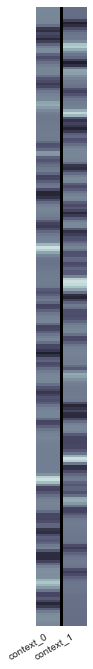

In [38]:
X = check_design("context_single_by_frame")
X.plot()

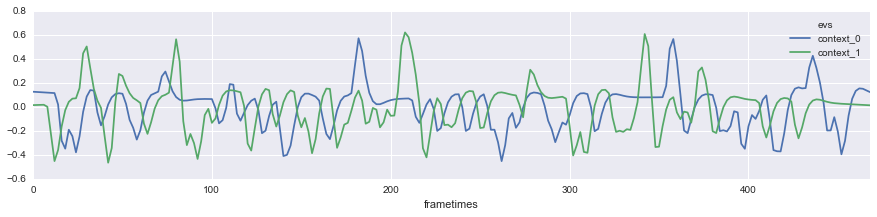

In [39]:
X.design_matrix.plot(figsize=(15, 3));

##  Context single by CPE

In [40]:
def context_single_by_cpe_quartiles(data, subj):
    
    # Compute evenly sized bins from quartiles of the CPE distribution
    bins = np.percentile(data.pe_context, [25, 50, 75, 100])
    bins = np.concatenate([[0], bins])
    labels = ["cpe_1", "cpe_2", "cpe_3", "cpe_4"]
    quartiles = pd.cut(data.pe_context, bins=bins, labels=labels)
    data.loc[:, "cpe_quartile"] = quartiles.astype(object)

    # Convert the semantic context column to a numeric one
    data["context_numeric"] = data.context.map({"motion": 1, "color":- 1})
    
    # Loop over the quartiles of CPE
    regressors = []
    for label in labels:

        quartile_data = data.query("cpe_quartile == @label")

        # Build the regressor
        context = build_parametric_ev(quartile_data, onset="cue_onset", name=label,
                                      value="context_numeric", duration="model_dur", center=0)

        regressors.append(context)
        

    save_design(regressors, subj, "context_single_by_cpe_quartiles")

In [41]:
make_designs(context_single_by_cpe_quartiles)

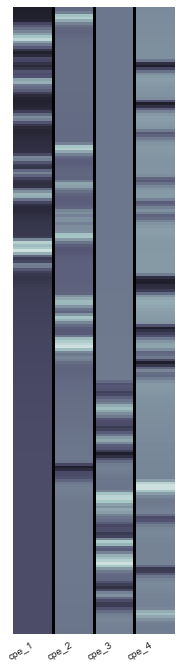

In [42]:
X = check_design("context_single_by_cpe_quartiles", run=7)
X.plot()

----

## CPE quartiles

Model with task events split into quartiles of CPE and an error regressor

In [43]:
def cpe_quartiles(data, subj):
    
    # Compute evenly sized bins from quartiles of the CPE distribution
    bins = np.percentile(data.pe_context, [25, 50, 75, 100])
    bins = np.concatenate([[0], bins])
    labels = ["cpe_1", "cpe_2", "cpe_3", "cpe_4"]
    quartiles = pd.cut(data.pe_context, bins=bins, labels=labels)
    data.loc[:, "cpe_quartile"] = quartiles.astype(object)

    # Subsets of the dataset
    data_correct = data.query("correct")
    data_error = data.query("not correct")

    # Four regressors for each quartiles
    cpe = build_condition_ev(data_correct, onset="cue_onset",
                             condition="cpe_quartile", duration="model_dur")

    # One regressor for all error trials
    error = build_simple_ev(data_error, onset="cue_onset", name="error",
                            duration="model_dur")

    save_design([cpe, error], subj, "cpe_quartiles")    

In [44]:
make_designs(cpe_quartiles)

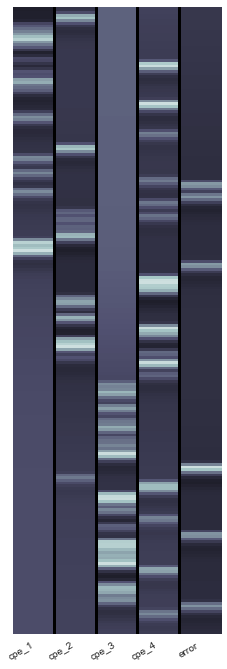

In [45]:
X = check_design("cpe_quartiles", run=7)
X.plot()

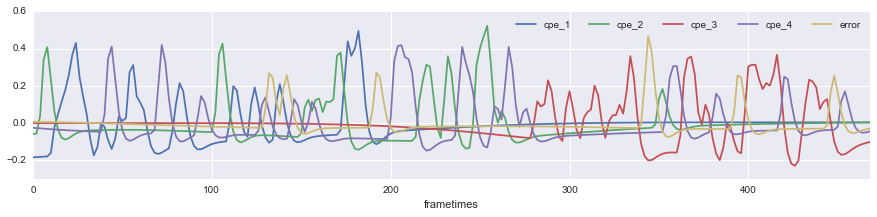

In [46]:
X.design_matrix.plot(figsize=(15, 3))
plt.legend(ncol=5, loc="best");

---

## CPE quartiles split by context

Four bins of each CPE for each context, correct trials only

In [47]:
def cpe_quartiles_by_context(data, subj):
    
    # Compute evenly sized bins from quartiles of the CPE distribution
    bins = np.percentile(data.pe_context, [25, 50, 75, 100])
    bins = np.concatenate([[0], bins])
    labels = ["_1", "_2", "_3", "_4"]
    quartiles = pd.cut(data.pe_context, bins=bins, labels=labels).astype(object)
    context_quartiles = data.context + quartiles
    data.loc[:, "context_quartiles"] = context_quartiles

    # Subset the correct trials
    data_corr = data.query("correct")

    # Build the dummy regressors
    quartiles = build_condition_ev(data_corr, onset="cue_onset",
                                   condition="context_quartiles", duration="model_dur")

    save_design([quartiles], subj, "cpe_quartiles_by_context")

In [48]:
make_designs(cpe_quartiles_by_context)

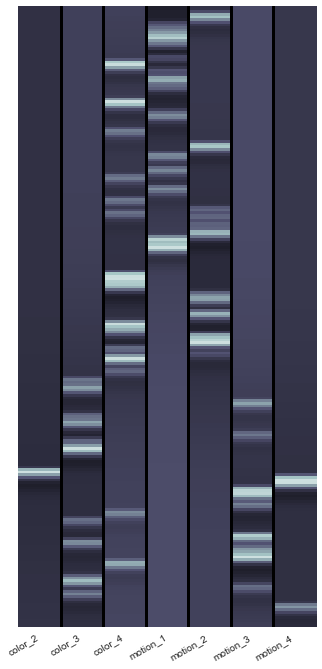

In [49]:
X = check_design("cpe_quartiles_by_context", run=7)
X.plot()

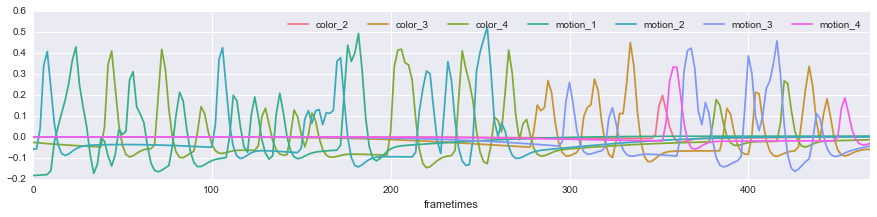

In [50]:
X.design_matrix.plot(figsize=(15, 3), color=sns.husl_palette(7))
plt.legend(ncol=7);

---

## CPE quartiles split by cue and stimulus events

In [51]:
def cpe_cuestim_quartiles(data, subj):
    
    # Compute evenly sized bins from quartiles of the CPE distribution
    bins = np.percentile(data.pe_context, [25, 50, 75, 100])
    bins = np.concatenate([[0], bins])
    for kind in ["cue", "stim"]:
        labels = ["{}_cpe_{:d}".format(kind, i) for i in range(1, 5)]
        quartiles = pd.cut(data.pe_context, bins=bins, labels=labels)
        data.loc[:, "cpe_{}_quartile".format(kind)] = quartiles.astype(object)

    # Subsets of the dataset
    data_correct = data.query("correct")
    data_error = data.query("not correct")

    # Four regressors for each quartiles
    cpe_cue = build_condition_ev(data_correct.query("trial_type != 'later'"),
                                 onset="cue_onset", condition="cpe_cue_quartile",
                                 duration="model_dur")
    cpe_stim = build_condition_ev(data_correct.query("trial_type != 'catch'"),
                                  onset="stim_onset", condition="cpe_stim_quartile",
                                  duration="model_dur")

    # One regressor for all error trials
    error = build_simple_ev(data_error, onset="cue_onset", name="error",
                            duration="model_dur")

    save_design([cpe_cue, cpe_stim, error], subj, "cpe_cuestim_quartiles")    

In [52]:
make_designs(cpe_cuestim_quartiles)

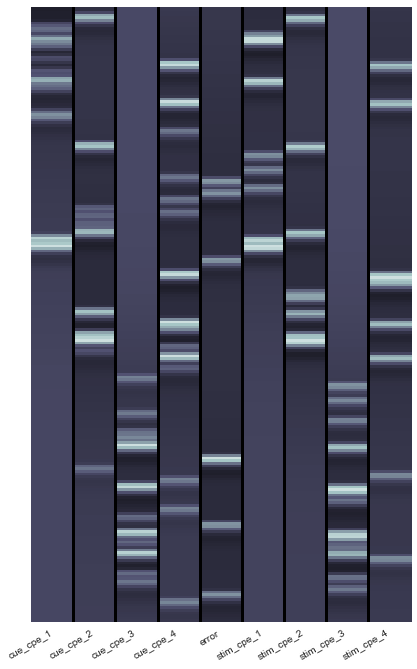

In [53]:
X = check_design("cpe_cuestim_quartiles", run=7)
X.plot()

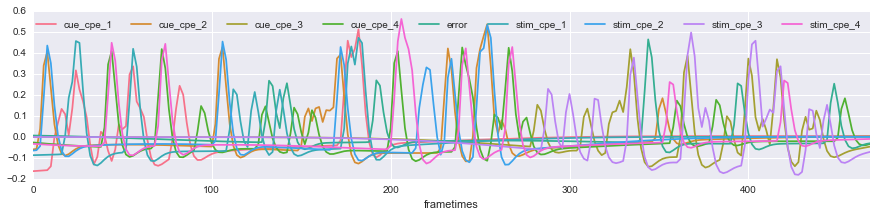

In [54]:
X.design_matrix.plot(figsize=(15, 3), color=sns.husl_palette(9))
plt.legend(ncol=9);

---

## CPE quartiles controling for context switches 

In [55]:
def cpe_quartiles_with_switch(data, subj):
    
    # Compute evenly sized bins from quartiles of the CPE distribution
    bins = np.percentile(data.pe_context, [25, 50, 75, 100])
    bins = np.concatenate([[0], bins])
    labels = ["cpe_1", "cpe_2", "cpe_3", "cpe_4"]
    quartiles = pd.cut(data.pe_context, bins=bins, labels=labels)
    data.loc[:, "cpe_quartile"] = quartiles.astype(object)

    # Subsets of the dataset
    data_correct = data.query("correct")
    data_switch = data_correct.query("context_switch")
    data_error = data.query("not correct")

    # Four regressors for each quartiles
    cpe = build_condition_ev(data_correct, onset="cue_onset",
                             condition="cpe_quartile", duration="model_dur")

    # Main effect of context switches
    switch = build_simple_ev(data_switch, onset="cue_onset",
                             name="context_switch", duration="model_dur")

    # One regressor for all error trials
    error = build_simple_ev(data_error, onset="cue_onset", name="error",
                            duration="model_dur")

    save_design([cpe, switch, error], subj, "cpe_quartiles_with_switch")    

In [56]:
make_designs(cpe_quartiles_with_switch)

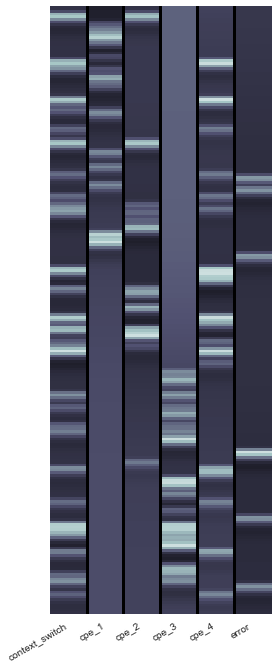

In [57]:
X = check_design("cpe_quartiles_with_switch", run=7)
X.plot()

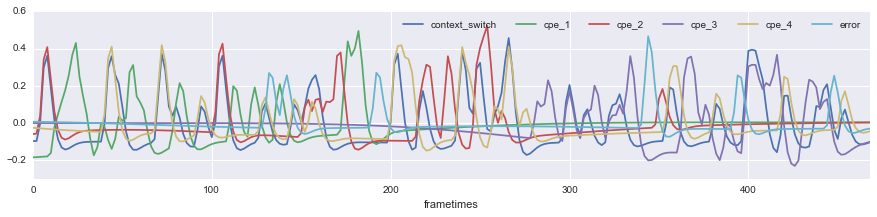

In [58]:
X.design_matrix.plot(figsize=(15, 3))
plt.legend(ncol=6);